# **Model Evaluation**

## Objectives

* Evaluate the performance of the optimized Gradient Boosting and XGBRegressor models.
* Analyze feature importance to understand which variables have the most influence on house prices.
* Ensure that the chosen model meets the business requirement (R2 ≥ 0.75)

## Inputs

* The prepared dataset (`HousePricesFeatures.csv`)
* Libraries for machine learning and data handling, including:
  - **pandas** for data manipulation.
  - **sklearn** for machine learning and model training.
  - **matplotlib** and **seaborn** for visualizations.
  - **joblib** for saving and loading models.


## Outputs

* The optimized XGBRegressor model is saved as: jupyter_notebooks/outputs/best_model/best_xgboost_model.pkl.
* Visualization of feature importance.
* Model evaluation metrics (MSE, R2).
* Conclusions regarding the model's performance and usability.


___

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues'

___

### Imports

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump 
from xgboost import XGBRegressor

# Load data

In [2]:
df_selected = pd.read_csv("outputs/datasets/collection/HousePricesFeaturesSelected.csv")
df_selected.head()

,SalePrice,OverallQual,GrLivArea,GarageArea,TotalBsmtSF
0,208500.0,7,7.621711,204.517915,198.284295
1,181500.0,6,7.303622,177.329636,264.601145
2,223500.0,7,7.667292,222.579733,209.206786
3,140000.0,7,7.625993,232.664362,180.779930
4,250000.0,8,7.885038,288.451992,246.150776


In [3]:
# Define features and target variable
X = df_selected.drop('SalePrice', axis=1)
y = np.log1p(df_selected['SalePrice'])  # Log-transform the target variable

In [4]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

##### **Gradient Boosting Regressor optimization**

In [5]:
pipeline = Pipeline([
    ('model', GradientBoostingRegressor(random_state=42))  # Model to train
])

# Define the parameters for randomized search
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# Perform randomized search for hyperparameters
random_search = RandomizedSearchCV(
    pipeline, param_distributions=param_grid, n_iter=20, cv=5, n_jobs=-1, verbose=2, random_state=42
)

# Fit the randomized search to the training data
random_search.fit(X_train, y_train)

# Print the best hyperparameters found and evaluate the model
print(f"Best hyperparameters from random search: {random_search.best_params_}")

# Evaluate the optimized model
optimized_model = random_search.best_estimator_
y_pred_optimized = optimized_model.predict(X_test)

# Inverse log-transform predictions and target
y_test_original = np.expm1(y_test)
y_pred_original = np.expm1(y_pred_optimized)

# Calculate metrics
mse_optimized = mean_squared_error(y_test_original, y_pred_original)
r2_optimized = r2_score(y_test_original, y_pred_original)

print(f"Optimized MSE: {mse_optimized}")
print(f"Optimized R2 Score: {r2_optimized}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=200; total time=   4.6s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=200; total time=   4.7s
[CV] END model__max_depth=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=200; total time=   5.0s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=200; total time=   4.9s
[CV] END model__max_depth=20, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=300; total time=   6.4s
[CV] END model__max_depth=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=200; total time=   5.2s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=200; total time=   5.0s
[CV] END model__max_depth=None, model__min_samples_leaf=2, model__min_samples_split=2

##### **XGBRegressor optimization**

In [6]:
pipeline = Pipeline([
    ('model', XGBRegressor(random_state=42))  # Model to train
])

# Define the parameters for randomized search
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20, 30],
    'model__learning_rate': [0.01, 0.05, 0.1],  # Typical learning rates for XGBoost
    'model__subsample': [0.8, 1.0],  # Subsample ratio
    'model__colsample_bytree': [0.8, 1.0],  # Column subsample ratio
}


# Perform randomized search for hyperparameters
random_search = RandomizedSearchCV(
    pipeline, param_distributions=param_grid, n_iter=20, cv=5, n_jobs=-1, verbose=2, random_state=42
)

# Fit the randomized search to the training data
random_search.fit(X_train, y_train)

# Print the best hyperparameters found and evaluate the model
print(f"Best hyperparameters from random search: {random_search.best_params_}")

# Evaluate the optimized model
optimized_model = random_search.best_estimator_
y_pred_optimized = optimized_model.predict(X_test)

# Inverse log-transform predictions and target
y_test_original = np.expm1(y_test)
y_pred_original = np.expm1(y_pred_optimized)

# Calculate metrics
mse_optimized = mean_squared_error(y_test_original, y_pred_original)
r2_optimized = r2_score(y_test_original, y_pred_original)

print(f"Optimized MSE: {mse_optimized}")
print(f"Optimized R2 Score: {r2_optimized}")


xgb_model = optimized_model.named_steps['model']


print(f"Saving the best model: {type(xgb_model)}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.05, model__max_depth=None, model__n_estimators=100, model__subsample=1.0; total time=   0.5s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.05, model__max_depth=None, model__n_estimators=100, model__subsample=1.0; total time=   0.4s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=30, model__n_estimators=100, model__subsample=1.0; total time=   1.4s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=30, model__n_estimators=100, model__subsample=1.0; total time=   1.5s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=30, model__n_estimators=100, model__subsample=1.0; total time=   1.4s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=30, model__n_estimators=100, model__subsample=1.0; total time=   1.5s
[CV] END model__colsam

#### **Conclusion:**

Both models worked well, but **Gradient Boosting Regressor** performed slightly better than **XGBRegressor**.

- **R² Score**:
  - **Gradient Boosting: 0.863**
  - **XGBRegressor: 0.845**

  **Gradient Boosting** explains more of the variation in house prices.

- **Mean Squared Error (MSE)**:
  - **Gradient Boosting: 953,330,178**
  - **XGBRegressor: 1,083,823,768**

  **Gradient Boosting** has a lower error, which means its predictions are closer to the actual prices.

#### **Decision**:
Because **Gradient Boosting** performs better, it is chosen as the final model to predict house prices.


In [9]:
# Spara den optimerade Gradient Boosting-modellen
dump(optimized_model, 'outputs/best_model/best_gradient_boosting_model.pkl')
print("Gradient Boosting model saved successfully.")

# Spara XGBoost-modellen
dump(xgb_model, 'outputs/best_model/best_xgboost_model.pkl')
print("XGBoost model saved successfully.")

Gradient Boosting model saved successfully.
XGBoost model saved successfully.


___

##### **Calculating Feature Importance**

In [10]:
# Calculate permutation importance
result = permutation_importance(optimized_model, X_test, y_test, n_repeats=10, random_state=42)

# Create a DataFrame to store the results
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

# Check the DataFrame
print(importance_df.head())

       Feature  Importance
0  OverallQual    0.542791
1    GrLivArea    0.188554
3  TotalBsmtSF    0.143993
2   GarageArea    0.069383


       Feature  Importance
0  OverallQual    0.542791
1    GrLivArea    0.188554
3  TotalBsmtSF    0.143993
2   GarageArea    0.069383


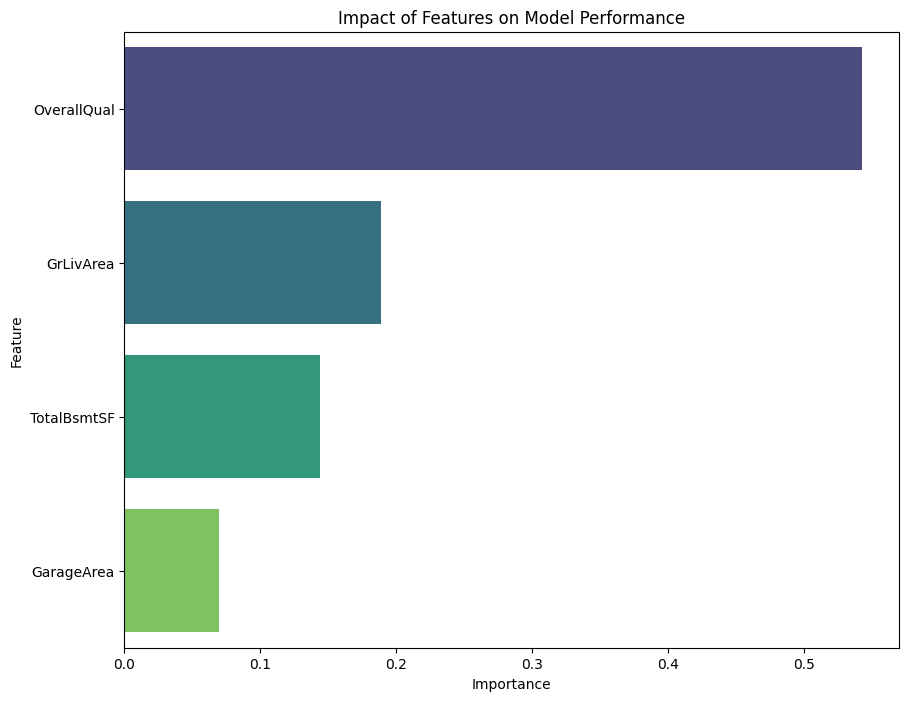

In [11]:
# Visualize permutation importance
plt.figure(figsize=(10, 8))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis", orient="h", hue='Feature')
plt.title("Impact of Features on Model Performance")
plt.xlabel("Importance")
plt.ylabel("Feature")

# Set the x-axis to start at 0
plt.xlim(left=0)

# Display the importance dataframe
print(importance_df)
plt.show()

### **Feature Importance Analysis**
- **OverallQual** is the most important feature and has the biggest impact on the model’s performance. This means that the overall quality of a house is a key factor in determining its price. For real estate developers or sellers, this suggests that improving the house's quality can lead to higher prices.

- **GrLivArea (living area)** and **BsmtFinSF1 (finished basement area)** are also important for pricing. Larger living spaces and more usable basement areas usually result in higher house prices. This is useful for builders and sellers to know that increasing house size or usable space can increase value.

- Features like **GarageArea** and **2ndFlrSF (second floor area)** have smaller, but still important, effects on the model’s predictions. While these features are not as critical as the others, they still influence pricing, showing that buyers may care about having more garage space or a second floor, which could increase the house price if there is one..
